In [1]:
%load_ext autoreload
%autoreload 2

In [5]:
# To load the environment variable defined in the .env file
from dotenv import load_dotenv
load_dotenv();

In [35]:
import pandas as pd
import src.data.NHLDataManager as DataManager
data_manager = DataManager.NHLDataManager()

In [38]:
shot_types = ['Tip-In', 'Wrist Shot', 'Snap Shot', 'Backhand', 'Slap Shot']
game_numbers = data_manager.get_game_numbers(2018, "Playoffs")
goals_and_shots = pd.DataFrame()
for game in game_numbers:
    goals_and_shots = pd.concat([goals_and_shots, data_manager.get_goals_and_shots_df(2018, "Regular", game)[["Type", "Shot Type"]]])
goals_and_shots.head()

,Type,Shot Type
0,GOAL,Wrist Shot
1,GOAL,Wrist Shot
2,GOAL,Wrist Shot
3,SHOT,Wrist Shot
4,SHOT,Wrist Shot


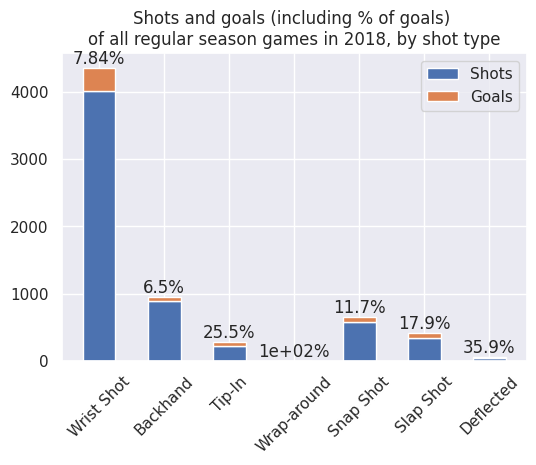

In [39]:
# Q1

import matplotlib.pyplot as plt
from collections import Counter

# filter out NaN values
goals_and_shots = goals_and_shots.dropna()
labels = goals_and_shots["Shot Type"].unique() # not sure which shot types are to be kept?

# Grab counts
shots = goals_and_shots[goals_and_shots["Type"] == "SHOT"]
goals = goals_and_shots[goals_and_shots["Type"] == "GOAL"]
shot_counts = Counter(shots["Shot Type"])
goal_counts = Counter(goals["Shot Type"])
shot_counts_filtered = []
goal_counts_filtered = []
for l in labels:
    shot_counts_filtered.append(shot_counts[l])
    goal_counts_filtered.append(goal_counts[l])
    

fig, ax = plt.subplots(figsize=(6, 4))
p1 = ax.bar(labels, shot_counts_filtered, width=0.5, label='Shots')
p2 = ax.bar(labels, goal_counts_filtered, width=0.5, bottom=shot_counts_filtered, label='Goals')
goal_percent_by_shot_type = [(goal_counts_filtered[i]/(shot_counts_filtered[i]+goal_counts_filtered[i]))*100 for i in range(len(labels))]
plt.bar_label(p2, labels=[f"{p:.3}%" for p in goal_percent_by_shot_type])
plt.xticks(rotation=45)
plt.title("Shots and goals (including % of goals) \nof all regular season games in 2018, by shot type")
plt.legend()
plt.show()

In [ ]:
from tqdm.auto import tqdm

# Q2
shots_by_season = []
skipped = 0
for season in [2018, 2019, 2020]:
    for season_type in ("Regular", "Playoffs"):
        distance_data = pd.DataFrame()
        game_numbers = data_manager.get_game_numbers(season, season_type)
        for game in tqdm(game_numbers):
            try:
                distance_data = pd.concat([distance_data, data_manager.get_goals_and_shots_df_standardised(season, season_type, game)[["Type", "Shot Type", "st_X", "st_Y"]]])
            except:
                # Sometimes the rinkSide isn't provided...
                # For now we could skip it?
                skipped += 1
                continue
        shots_by_season.append(distance_data)
print(f"Skipped games: {skipped}")

In [10]:
import matplotlib.pyplot as plt
import numpy as np

distances_by_season = []

for season in shots_by_season:
    season = season.dropna()
    distance = np.linalg.norm((season.iloc[:,2:4] - np.array([89,0])).astype(float), axis=1) # Goal is located at (89, 0)
    df = pd.DataFrame()
    df['Type'] = season.Type
    df['distance'] = distance
    distances_by_season.append(df)

In [11]:
for season in distances_by_season:
    print(season.distance.min(), season.distance.max())

1.0 189.6549498431296
3.0 187.6725872363889
1.4142135623730951 188.0239346466295
2.23606797749979 187.52333188166213
1.0 188.0239346466295
1.4142135623730951 185.3887806745597


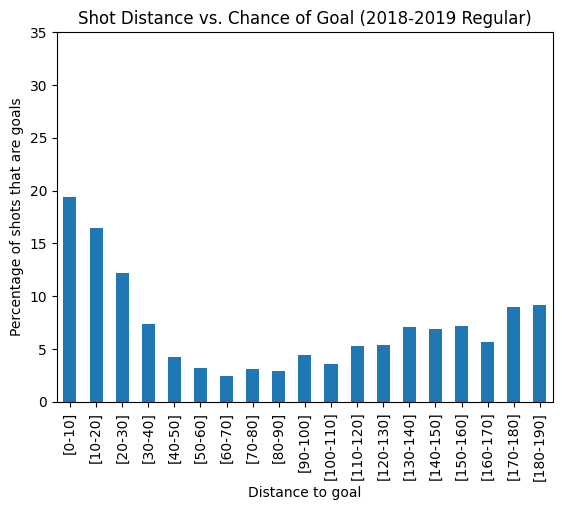

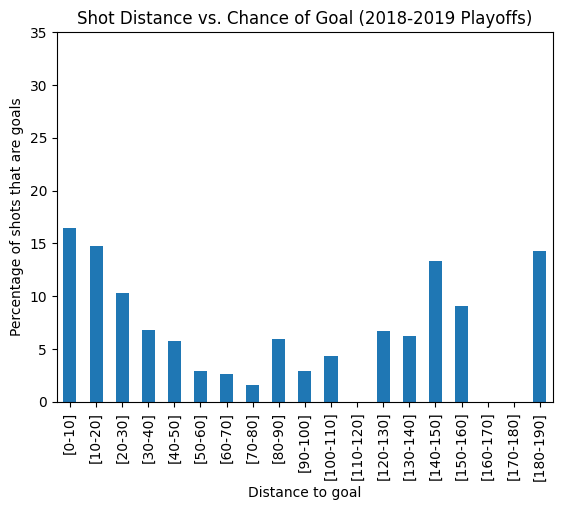

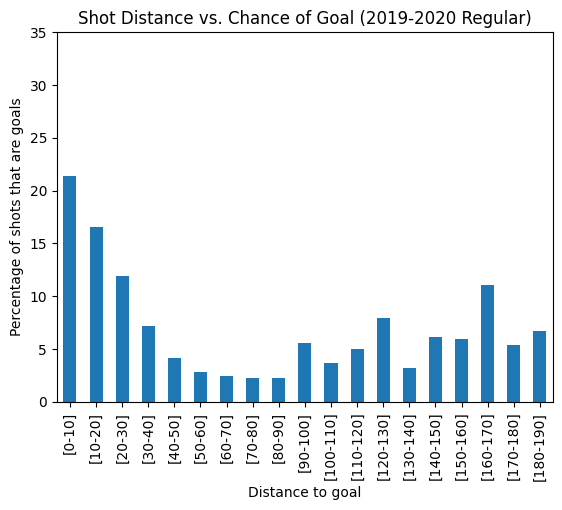

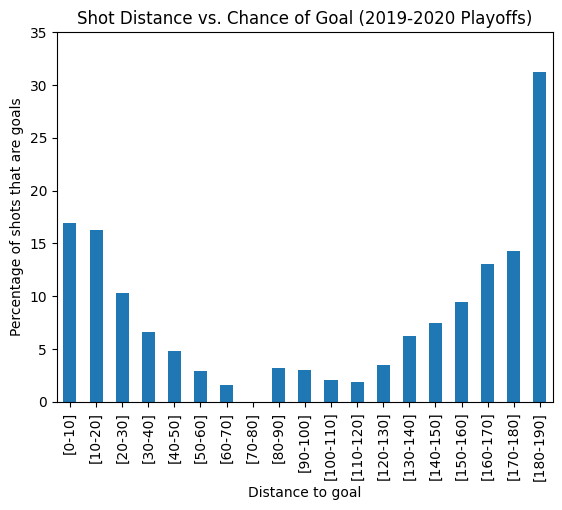

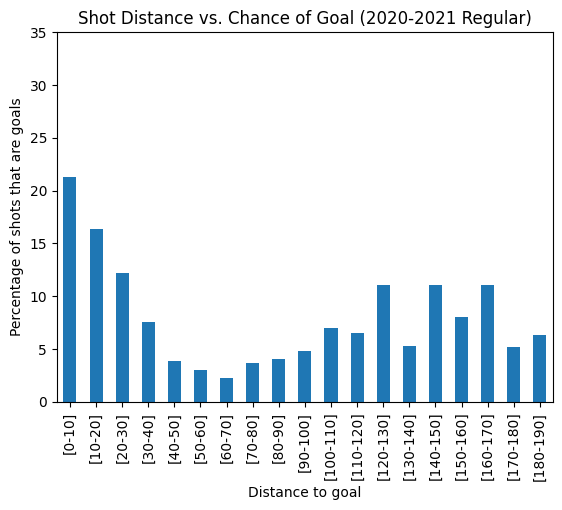

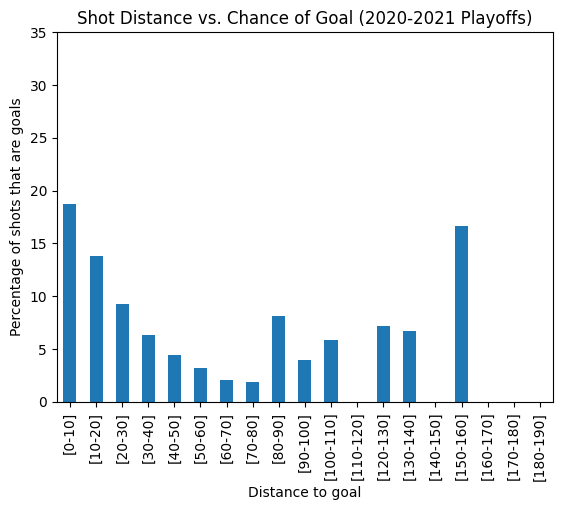

In [12]:
i = 0
for s in [2018, 2019, 2020]:
    for season_type in ("Regular", "Playoffs"):
        season = distances_by_season[i]
        shots = season[season.Type == 'SHOT'].distance
        goals = season[season.Type == 'GOAL'].distance
        bins = [i*10 for i in range(20)]
        bin_labels = [f"[{i*10}-{(i+1)*10}]" for i in range(19)]
        shots_bins = pd.cut(shots, bins=bins, labels=bin_labels).value_counts(sort=False)
        goals_bins = pd.cut(goals, bins=bins, labels=bin_labels).value_counts(sort=False)
        goal_percent = (goals_bins / (shots_bins + goals_bins)) * 100
        goal_percent.plot.bar()
        plt.ylim(0, 35)
        plt.xlabel("Distance to goal")
        plt.ylabel("Percentage of shots that are goals")
        plt.title(f"Shot Distance vs. Chance of Goal ({s}-{s+1} {season_type})")
        plt.show()
        i += 1

In [13]:
# Q3
df = shots_by_season[0].dropna()
df['distance'] = distances_by_season[0].distance
df['distance_bin'] = pd.cut(df.distance, bins=bins, labels=bin_labels)
df = df.drop(labels=['st_X', 'st_Y', 'distance'], axis=1)
df

/tmp/ipykernel_21840/2672877359.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['distance'] = distances_by_season[0].distance
/tmp/ipykernel_21840/2672877359.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['distance_bin'] = pd.cut(df.distance, bins=bins, labels=bin_labels)


,Type,Shot Type,distance_bin
0,GOAL,Wrap-around,[0-10]
1,GOAL,Snap Shot,[20-30]
2,GOAL,Snap Shot,[20-30]
3,GOAL,Slap Shot,[30-40]
4,GOAL,Snap Shot,[10-20]
...,...,...,...
55,SHOT,Wrist Shot,[30-40]
56,SHOT,Wrist Shot,[20-30]
57,SHOT,Wrist Shot,[10-20]
58,SHOT,Wrist Shot,[10-20]


In [14]:
import math
heatmap_data = np.zeros((len(bin_labels), len(labels)))
groups = df.groupby(['Shot Type', 'distance_bin']).value_counts()
for i, bin_label in enumerate(bin_labels):
    for j, shot_type in enumerate(labels):
        group = groups[shot_type, bin_label]
        goal_percent = group['GOAL'] / group.sum() * 100
        heatmap_data[i,j] = goal_percent
        # heatmap_data[i,j] = goal_percent if not math.isnan(goal_percent) else 0
heatmap_data = pd.DataFrame(heatmap_data)
heatmap_data.columns = labels
heatmap_data.index = bin_labels

/tmp/ipykernel_21840/1215618757.py:7: RuntimeWarning: invalid value encountered in long_scalars
  goal_percent = group['GOAL'] / group.sum() * 100


In [15]:
heatmap_data

,Wrap-around,Snap Shot,Slap Shot,Wrist Shot,Backhand,Tip-In,Deflected
[0-10],48.039216,8.535179,3.002309,15.155048,31.542289,47.826087,38.461538
[10-20],6.976744,16.572311,5.466541,14.853713,18.097208,36.514119,29.874214
[20-30],3.076923,21.509886,11.529680,11.754044,4.435798,9.385666,12.682927
[30-40],0.000000,13.617525,17.244526,6.464133,0.451467,0.886525,4.054054
[40-50],0.000000,5.429553,16.533066,3.241590,0.166389,0.941620,2.762431
[50-60],0.000000,2.890625,15.609265,2.064715,0.411523,0.766284,2.727273
[60-70],0.000000,1.498929,10.216718,2.100494,0.464037,0.990099,1.960784
[70-80],0.000000,3.508772,2.666667,3.478261,2.678571,0.000000,0.000000
[80-90],0.000000,0.000000,0.000000,4.444444,2.197802,0.000000,0.000000
[90-100],0.000000,3.636364,4.166667,5.514706,2.040816,0.000000,0.000000


<AxesSubplot: >

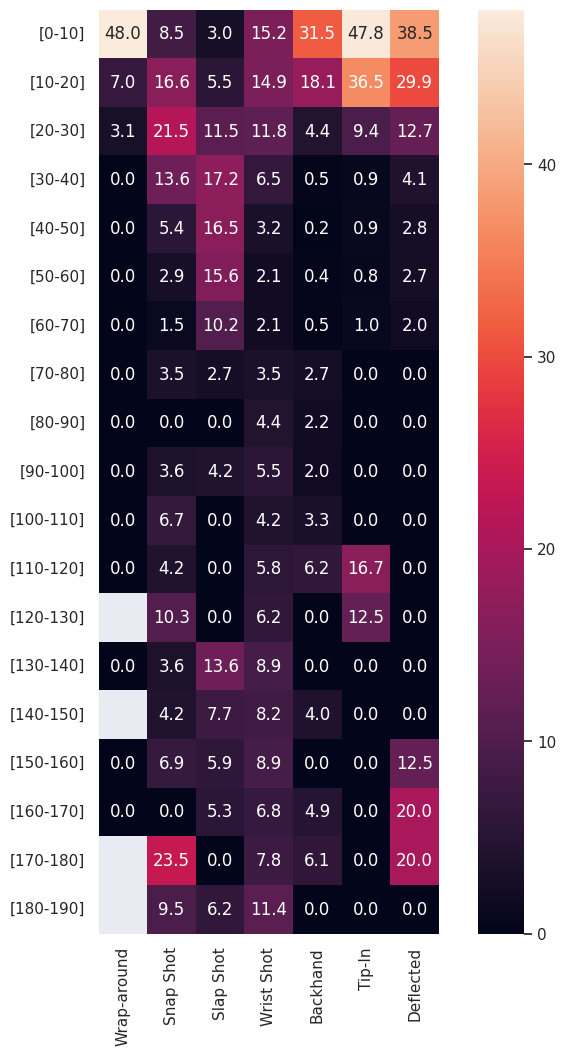

In [24]:
import seaborn as sns
sns.set(rc={"figure.figsize":(10, 12)})
sns.heatmap(heatmap_data, square=True, annot=True, fmt=".1f")